In [17]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiConnect_1st

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/aiConnect_1st


# **라이브러리**

In [18]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from datetime import datetime, timedelta

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

# **파라미터 설정**

In [19]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# **데이터 전처리**

## 데이터 로드

In [15]:
DF = pd.read_csv('./data/train.csv')
df = DF.copy()
df

,신고접수번호,접수경로,신고접수일시,시군구,접수분류,긴급구조종류
0,JGT2IBW4,이동전화,20130101_0001,NaN,안내,NaN
1,74ED11Z4,기타,20130101_0002,NaN,안내,NaN
2,B4I8RIBW,이동전화,20130101_0002,NaN,안내,NaN
3,482FI3AJ,이동전화,20130101_0003,북구,출동,구급
4,AR9N3QT4,이동전화,20130101_0004,NaN,안내,NaN
...,...,...,...,...,...,...
6415797,KAOUMKLU,기타,20220630_2354,NaN,안내,NaN
6415798,LAI1MQ2K,이동전화,20220630_2354,사상구,출동,구급
6415799,N5KF2ELA,이동전화,20220630_2356,동구,출동,구급
6415800,53Q98D6Z,의료지도연결,20220630_2358,NaN,안내,NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6415802 entries, 0 to 6415801
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   신고접수번호  object
 1   접수경로    object
 2   신고접수일시  object
 3   시군구     object
 4   접수분류    object
 5   긴급구조종류  object
dtypes: object(6)
memory usage: 293.7+ MB


In [21]:
df.isna().sum()

신고접수번호          0
접수경로           63
신고접수일시          0
시군구       2593124
접수분류            0
긴급구조종류    4015625
dtype: int64

In [22]:
df['접수경로'].value_counts()

이동전화          3559271
기타             908928
일반전화           867867
의료지도연결         834152
IP전화           135052
공중전화            44241
SMS신고           25947
사후각지            25826
영상신고             5603
MMS신고            4843
시스템입력            3029
모바일앱신고            581
WEB신고             362
전통시장신고             19
긴급신고통합앱            12
구급예약                4
승강기신고               1
수출입 위험물 신고          1
Name: 접수경로, dtype: int64

In [23]:
df['시군구'].value_counts()

부산진구    423537
해운대구    404063
연제구     333239
사하구     316186
북구      286544
사상구     248412
동래구     248271
남구      238725
금정구     238496
기장군     191147
수영구     183108
강서구     176159
동구      154398
서구      141731
영도구     140765
중구       97897
Name: 시군구, dtype: int64

In [24]:
df['접수분류'].value_counts()

안내    4014666
출동    2401136
Name: 접수분류, dtype: int64

In [25]:
df['긴급구조종류'].value_counts()

구급    1582608
기타     403642
구조     321461
화재      92466
Name: 긴급구조종류, dtype: int64

In [26]:
'''작은 데이터셋을 만들어서 코드 테스트'''
# _df = pd.read_csv('./train.csv')[:500000]
# _df.to_csv('train_small.csv', index=False)

'작은 데이터셋을 만들어서 코드 테스트'

## 시간대 이동

In [27]:
df['dt'] = df['신고접수일시'].apply(lambda x: datetime.strptime(x,'%Y%m%d_%H%M'))
df['_dt'] = df['dt'] + timedelta(hours=6) # 6 hours shift (18~08 -> 00~13)
df['_date'] = df._dt.dt.date.astype(str)
df['_hour'] = df._dt.dt.hour
df

,신고접수번호,접수경로,신고접수일시,시군구,접수분류,긴급구조종류,dt,_dt,_date,_hour
0,JGT2IBW4,이동전화,20130101_0001,NaN,안내,NaN,2013-01-01 00:01:00,2013-01-01 06:01:00,2013-01-01,6
1,74ED11Z4,기타,20130101_0002,NaN,안내,NaN,2013-01-01 00:02:00,2013-01-01 06:02:00,2013-01-01,6
2,B4I8RIBW,이동전화,20130101_0002,NaN,안내,NaN,2013-01-01 00:02:00,2013-01-01 06:02:00,2013-01-01,6
3,482FI3AJ,이동전화,20130101_0003,북구,출동,구급,2013-01-01 00:03:00,2013-01-01 06:03:00,2013-01-01,6
4,AR9N3QT4,이동전화,20130101_0004,NaN,안내,NaN,2013-01-01 00:04:00,2013-01-01 06:04:00,2013-01-01,6
...,...,...,...,...,...,...,...,...,...,...
6415797,KAOUMKLU,기타,20220630_2354,NaN,안내,NaN,2022-06-30 23:54:00,2022-07-01 05:54:00,2022-07-01,5
6415798,LAI1MQ2K,이동전화,20220630_2354,사상구,출동,구급,2022-06-30 23:54:00,2022-07-01 05:54:00,2022-07-01,5
6415799,N5KF2ELA,이동전화,20220630_2356,동구,출동,구급,2022-06-30 23:56:00,2022-07-01 05:56:00,2022-07-01,5
6415800,53Q98D6Z,의료지도연결,20220630_2358,NaN,안내,NaN,2022-06-30 23:58:00,2022-07-01 05:58:00,2022-07-01,5


## 시간별 신고량 집계

In [28]:
df = df[['_date', '_hour', '신고접수번호']].groupby(['_date', '_hour']).count().reset_index()

column_map = {'_date': 'date', '_hour': 'hour', '신고접수번호': 'y'}
df = df.rename(column_map, axis='columns')
df

,date,hour,y
0,2013-01-01,6,77
1,2013-01-01,7,81
2,2013-01-01,8,72
3,2013-01-01,9,45
4,2013-01-01,10,47
...,...,...,...
83227,2022-07-01,1,136
83228,2022-07-01,2,128
83229,2022-07-01,3,90
83230,2022-07-01,4,100


from matplotlib import pyplot as plt
df['hour'].plot(kind='hist', bins=20, title='hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='hour', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['hour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('hour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['hour'].plot(kind='line', figsize=(8, 4), title='hour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

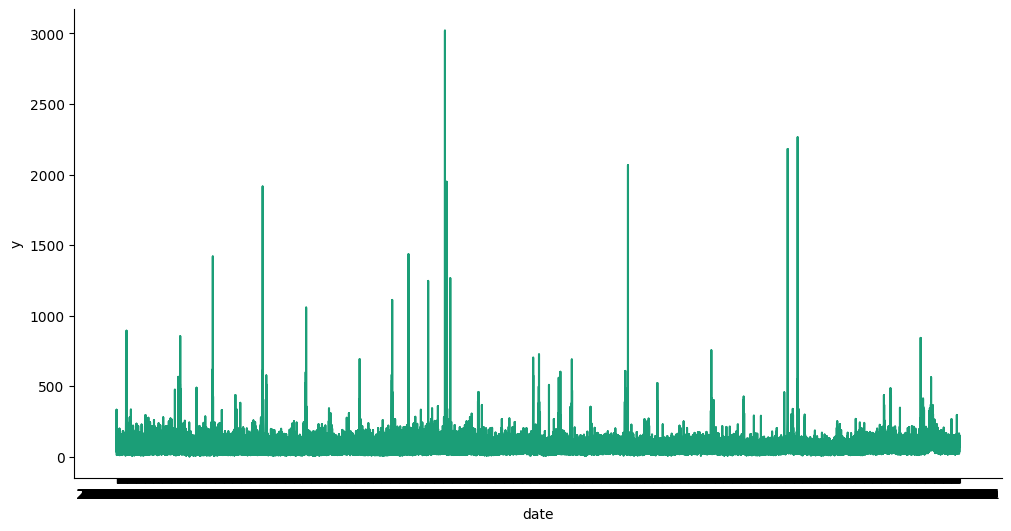

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('y')

In [35]:
import plotly.graph_objects as go

def _plot_series(series, series_name, series_index=0):
    palette = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)', 'rgb(231,41,138)',
               'rgb(102,166,30)', 'rgb(230,171,2)', 'rgb(166,118,29)', 'rgb(102,102,102)']

    xs = series['date']
    ys = series['y']

    return go.Scatter(x=xs, y=ys, mode='lines', name=series_name,
                      line=dict(color=palette[series_index % len(palette)]))

df_sorted = df.sort_values('date', ascending=True)
fig = go.Figure(_plot_series(df_sorted, ''))

fig.update_layout(
    autosize=False,
    width=1000,
    height=520,
    xaxis_title="date",
    yaxis_title="call volume",
)

fig.show()

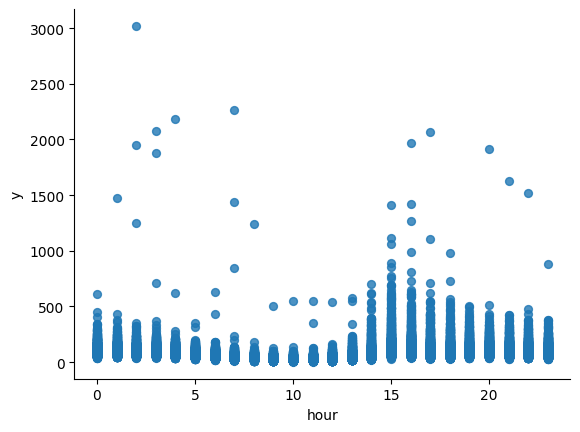

In [29]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='hour', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## 데이터 확인

In [36]:
# 일별로 24시간의 데이터가 모두 있는지 확인
check = df[['date', 'y']].groupby('date').count()
drop_dates = list(check[check['y'] != 24].index)

# column "date" -> index
df = df.set_index('date')
df = df.drop(index=drop_dates)
df

,hour,y
date,,
2013-01-02,0,97
2013-01-02,1,103
2013-01-02,2,102
2013-01-02,3,102
2013-01-02,4,61
...,...,...
2022-06-30,19,112
2022-06-30,20,115
2022-06-30,21,105


## 전처리 데이터 저장

In [37]:
df.to_csv('p_train.csv', index=True)

# ! 전처리 데이터 로드

In [38]:
df = pd.read_csv('./p_train.csv', index_col='date')
df

,hour,y
date,,
2013-01-02,0,97
2013-01-02,1,103
2013-01-02,2,102
2013-01-02,3,102
2013-01-02,4,61
...,...,...
2022-06-30,19,112
2022-06-30,20,115
2022-06-30,21,105


## 데이터 분할 (train/valid)

In [39]:
dates = list(set(df.index)) # 중복 날짜 제거
dates = sorted(dates)

valid_ratio = 0.3
train_idx = int(len(dates) * (1 - valid_ratio))

train_dates, valid_dates = dates[:train_idx], dates[train_idx:]
assert len(dates) == len(train_dates) + len(valid_dates)
print(f'{len(dates)} -> #train {len(train_dates)} #val {len(valid_dates)}')

3467 -> #train 2426 #val 1041


# Dataset

## 스케일러 정의

In [40]:
scaler = StandardScaler()
scaler.fit(df.loc[train_dates, 'y'].to_numpy().reshape((-1, 1)))

StandardScaler()

## Dataset 정의

In [41]:
class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, input_dim: int, output_dim: int, scaler: StandardScaler):
        self.df = df.copy()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.scaler = scaler

    def __len__(self):
        return len(self.df) - self.input_dim - self.output_dim + 1 # window size 24(=15+9)

    def __getitem__(self, idx) -> (torch.Tensor, torch.Tensor):
        x_begin, x_end = idx, idx + self.input_dim
        X = self.df.iloc[x_begin:x_end]['y']

        y_begin, y_end = x_end, x_end + self.output_dim
        y = self.df.iloc[y_begin:y_end]['y']

        X = X.to_numpy().reshape((-1, 1))
        y = y.to_numpy().reshape((-1, 1))

        X = self.scaler.transform(X).reshape(-1).astype(np.float32)
        y = self.scaler.transform(y).reshape(-1).astype(np.float32)

        return X, y

    def get_dates(self) -> list:
        return self.dates

# Model 정의

In [42]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.bn = nn.BatchNorm1d(256, 256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x


class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_size, hidden_size)


    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.fc3(x)
        return x

# 학습

## 학습 설정 _Hyperparameter

In [43]:
# 하이퍼파라미터 설정
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

n_epochs = 30
batch_size = 128
learning_rate = 0.001

input_dim = 15 # 18~8
output_dim = 9 # 9~17

In [44]:
train_df = df.loc[train_dates]
train_dataset = CustomDataset(train_df, input_dim=input_dim, output_dim=output_dim, scaler=scaler)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

valid_df = df.loc[valid_dates]
valid_dataset = CustomDataset(valid_df, input_dim=input_dim, output_dim=output_dim, scaler=scaler)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size)

# model = MLP(input_dim, output_dim)  # MLP
model = LSTM(input_dim, output_dim, hidden_size=128) # LSTM,

loss_function = nn.L1Loss() # MAE
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## 모델 학습

In [45]:
record_train_loss = []
record_valid_loss = []

for epoch in range(n_epochs):
    print(f'epoch #{epoch+1}')
    train_loss, valid_loss = 0, 0
    y_trues, y_preds = [], []

    # train
    model.train()
    for X, y in tqdm(train_data_loader):
        pred = model(X)

        loss = loss_function(y, pred) # true, pred
        train_loss += loss.detach().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_loader) + 1
    record_train_loss.append(train_loss)

    # valid
    model.eval()
    for X, y in tqdm(valid_data_loader):
        pred = model(X)

        loss = loss_function(y, pred) # true, pred
        valid_loss += loss.detach().numpy()

        y_true = y.detach().numpy()[0]
        y_pred = pred.detach().numpy()[0]

        y_trues.append(y_true)
        y_preds.append(y_pred)

    valid_loss /= len(valid_data_loader) + 1
    record_valid_loss.append(valid_loss)

    y_trues = scaler.inverse_transform(np.array(y_trues)).reshape(-1)
    y_preds = scaler.inverse_transform(np.array(y_preds)).reshape(-1)

    MAE = mean_absolute_error(y_trues, y_preds)
    MAPE = mean_absolute_percentage_error(y_trues, y_preds)

    print(f'train {train_loss:.6f} | valid {valid_loss:.6f} | MAE {MAE:.6f} | MAPE {MAPE:.6f}')

epoch #1


100%|██████████| 196/196 [00:14<00:00, 13.96it/s]


train 0.414850 | valid 0.368945 | MAE 30.214418 | MAPE 0.445596
epoch #2


100%|██████████| 196/196 [00:13<00:00, 14.70it/s]


train 0.368183 | valid 0.367431 | MAE 29.611265 | MAPE 0.432953
epoch #3


100%|██████████| 196/196 [00:14<00:00, 13.55it/s]


train 0.360229 | valid 0.375838 | MAE 28.576130 | MAPE 0.423920
epoch #4


100%|██████████| 196/196 [00:12<00:00, 15.38it/s]


train 0.354942 | valid 0.370440 | MAE 27.481146 | MAPE 0.402578
epoch #5


100%|██████████| 196/196 [00:13<00:00, 14.47it/s]


train 0.350790 | valid 0.367023 | MAE 26.518536 | MAPE 0.385096
epoch #6


100%|██████████| 196/196 [00:13<00:00, 14.11it/s]


train 0.347023 | valid 0.366604 | MAE 25.663292 | MAPE 0.371583
epoch #7


100%|██████████| 196/196 [00:13<00:00, 14.84it/s]


train 0.344830 | valid 0.366431 | MAE 24.897461 | MAPE 0.360190
epoch #8


100%|██████████| 196/196 [00:14<00:00, 13.95it/s]


train 0.343250 | valid 0.363992 | MAE 24.299837 | MAPE 0.349189
epoch #9


100%|██████████| 196/196 [00:12<00:00, 15.23it/s]


train 0.341778 | valid 0.364246 | MAE 23.704504 | MAPE 0.341755
epoch #10


100%|██████████| 196/196 [00:14<00:00, 13.83it/s]


train 0.340814 | valid 0.363378 | MAE 23.243490 | MAPE 0.333098
epoch #11


100%|██████████| 196/196 [00:13<00:00, 14.34it/s]


train 0.339882 | valid 0.363387 | MAE 22.557804 | MAPE 0.323921
epoch #12


100%|██████████| 196/196 [00:13<00:00, 14.20it/s]


train 0.338428 | valid 0.365883 | MAE 22.580809 | MAPE 0.317578
epoch #13


100%|██████████| 196/196 [00:14<00:00, 13.91it/s]


train 0.342066 | valid 0.364312 | MAE 21.915821 | MAPE 0.310735
epoch #14


100%|██████████| 196/196 [00:13<00:00, 14.94it/s]


train 0.339974 | valid 0.360334 | MAE 21.477280 | MAPE 0.302818
epoch #15


100%|██████████| 196/196 [00:13<00:00, 14.42it/s]


train 0.337787 | valid 0.355771 | MAE 21.405386 | MAPE 0.302332
epoch #16


100%|██████████| 196/196 [00:12<00:00, 15.55it/s]


train 0.335935 | valid 0.351405 | MAE 21.458817 | MAPE 0.302296
epoch #17


100%|██████████| 196/196 [00:13<00:00, 14.08it/s]


train 0.335068 | valid 0.354197 | MAE 21.245775 | MAPE 0.297257
epoch #18


100%|██████████| 196/196 [00:13<00:00, 14.90it/s]


train 0.335248 | valid 0.350446 | MAE 21.006275 | MAPE 0.296524
epoch #19


100%|██████████| 196/196 [00:12<00:00, 15.43it/s]


train 0.333736 | valid 0.354028 | MAE 20.947260 | MAPE 0.302395
epoch #20


100%|██████████| 196/196 [00:13<00:00, 14.26it/s]


train 0.333574 | valid 0.350539 | MAE 20.818369 | MAPE 0.297204
epoch #21


100%|██████████| 196/196 [00:12<00:00, 15.37it/s]


train 0.333335 | valid 0.351479 | MAE 20.493320 | MAPE 0.293351
epoch #22


100%|██████████| 196/196 [00:13<00:00, 14.09it/s]


train 0.333587 | valid 0.342688 | MAE 20.441185 | MAPE 0.293083
epoch #23


100%|██████████| 196/196 [00:12<00:00, 15.15it/s]


train 0.331010 | valid 0.343236 | MAE 20.401905 | MAPE 0.291516
epoch #24


100%|██████████| 196/196 [00:14<00:00, 13.86it/s]


train 0.330499 | valid 0.370726 | MAE 20.273876 | MAPE 0.288297
epoch #25


100%|██████████| 196/196 [00:13<00:00, 14.53it/s]


train 0.332949 | valid 0.341775 | MAE 20.230133 | MAPE 0.289088
epoch #26


100%|██████████| 196/196 [00:12<00:00, 15.36it/s]


train 0.332153 | valid 0.343660 | MAE 20.160355 | MAPE 0.288409
epoch #27


100%|██████████| 196/196 [00:14<00:00, 13.87it/s]


train 0.337169 | valid 0.344960 | MAE 20.164545 | MAPE 0.288140
epoch #28


100%|██████████| 196/196 [00:12<00:00, 15.64it/s]


train 0.331407 | valid 0.344543 | MAE 19.849255 | MAPE 0.286383
epoch #29


100%|██████████| 196/196 [00:13<00:00, 14.37it/s]


train 0.329379 | valid 0.339924 | MAE 19.801252 | MAPE 0.285388
epoch #30


100%|██████████| 196/196 [00:12<00:00, 15.43it/s]

train 0.331897 | valid 0.339353 | MAE 19.728382 | MAPE 0.282223


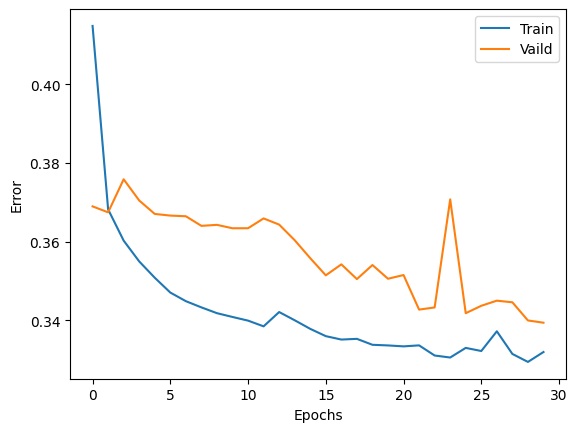

In [48]:
# 오차 추이
plt.plot(range(len(record_train_loss)), record_train_loss, label="Train")
plt.plot(range(len(record_valid_loss)), record_valid_loss, label="Vaild")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 예측값 시각화

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# valid
y_trues, y_preds = [], []
MAE, MAPE = 0, 0

model.eval()
for X, y in tqdm(valid_data_loader):
    pred = model(X)

    y_true = y.detach().numpy()[0]
    y_pred = pred.detach().numpy()[0]

    y_trues.append(y_true)
    y_preds.append(y_pred)

y_trues = scaler.inverse_transform(np.array(y_trues)).reshape(-1)
y_preds = scaler.inverse_transform(np.array(y_preds)).reshape(-1)

MAE = mean_absolute_error(y_trues, y_preds)
MAPE = mean_absolute_percentage_error(y_trues, y_preds)

fig = make_subplots(rows=1, cols=1)
fig.update_layout(title_text=f'prediction on daily (MAE: {MAE:.4f} MAPE: {MAPE*100:.2f}%)',
                  height=500,
                  width=1200)

fig.add_trace(go.Scatter(x=list(range(len(y_trues))), y=y_trues, name='y_true'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(len(y_trues))), y=y_preds, name='y_pred'), row=1, col=1)
fig.show()

100%|██████████| 196/196 [00:16<00:00, 11.86it/s]


# 제출

## 테스트용 Dataset 정의

In [52]:
class TestDataset(Dataset):
    def __init__(self, df: pd.DataFrame, dates: list, scaler: StandardScaler):
        self.df = df.copy()
        self.dates = dates
        self.scaler = scaler

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx) -> (torch.Tensor, torch.Tensor):
        date = self.dates[idx]

        select_data = self.df.loc[date]
        X = select_data['y'].to_numpy().reshape((-1, 1))
        X = self.scaler.transform(X).reshape(-1).astype(np.float32)

        return torch.from_numpy(X)

    def get_input_dimension(self) -> int:
        return 15 # 0 ~ 14 (6h shifted)

    def get_output_dimension(self) -> int:
        return 9 # 14 ~ 23 (6h shifted)

    def get_dates(self) -> list:
        return self.dates

## 테스트 데이터 전처리

In [53]:
df = pd.read_csv('./data/test.csv')
df['dt'] = df['신고접수일시'].apply(lambda x: datetime.strptime(x,'%Y%m%d_%H%M'))
df['_dt'] = df['dt'] + timedelta(hours=6) # 6 hours shift (21~08 -> 00~14)
df['date'] = df._dt.dt.date.astype(str)
df['hour'] = df._dt.dt.hour

df = df[['date', 'hour', '신고접수번호']].groupby(['date', 'hour']).count().reset_index()

column_map = {'_date': 'date', '_hour': 'hour', '신고접수번호': 'y'}
df = df.rename(column_map, axis='columns')
df

,date,hour,y
0,2022-07-01,0,150
1,2022-07-01,1,136
2,2022-07-01,2,128
3,2022-07-01,3,90
4,2022-07-01,4,100
...,...,...,...
1600,2022-10-15,10,31
1601,2022-10-15,11,36
1602,2022-10-15,12,21
1603,2022-10-15,13,47


## 테스트 예측

In [54]:
df = df.set_index('date')
dates = df.index.unique().tolist()

test_dataset = TestDataset(df, dates=dates, scaler=scaler)
test_data_loader = DataLoader(test_dataset, batch_size=1)

# test
y_trues, y_preds = [], []
MAE, MAPE = 0, 0

model.eval()
for X in test_data_loader:
    pred = model(X)

    y_pred = pred.detach().numpy()[0]
    y_preds.append(y_pred)

y_preds = scaler.inverse_transform(np.array(y_preds))
y_preds = y_preds.reshape(-1)

## 제출 파일 생성

In [55]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['y'] = y_preds
submission.to_csv('submission.csv', index=False)

# 완료